# How does adaptive sampling influence post-trial inference?

The idea of this notebook is to explore the behaviour of post-inference techniques, especially (naive) frequentist and bayesian approaches to adaptive sampling.
We therefore generate a simple example and test out which biases occur.

Please note that the example and the policies are not necessarily **good**, but are designed to show how the biases occur.

## Assumptions:
Generated outcome may only depend on current context and treatment, which means especially no crossover effects and instantaneous effects.
While this will usually **not** be the case, an proper study design should enable analysis based on these assumptions.

## Running example

Let's consider we want to compare to treatments Treatment_1 and Treatment_2.
We assume Treatment_1 has an average treatment effect of 1, and Treatment_2 has an average treatment effect of 2 both with a variance of 0.1.
We first compare a frequentist analysis in an AB design. By simulating 10000 trials with 100 observations each and looking at the estimates

In [365]:
import numpy as np
import pandas as pd
import seaborn as sns

In [366]:
# Set some constants
n_trials = 10000
n_observations = 100

In [367]:
df = pd.DataFrame(columns=["outcome", "treatment", "trial"])
# Simple AB treatment schedule
df["treatment"] = [1,2] * n_observations * int(n_trials / 2)
df["trial"] = df.index // n_observations
df["outcome"] = (
    (df["treatment"] == 1) * np.random.normal(1,1, len(df)) +
    (df["treatment"] == 2) * np.random.normal(2,1, len(df))
)
df_fixed_schedule = df

The histogram of estimated treatment effects by using a simple mean of this schedule shows two similar gaussian bell curves with different means.

<Axes: xlabel='Count', ylabel='outcome'>

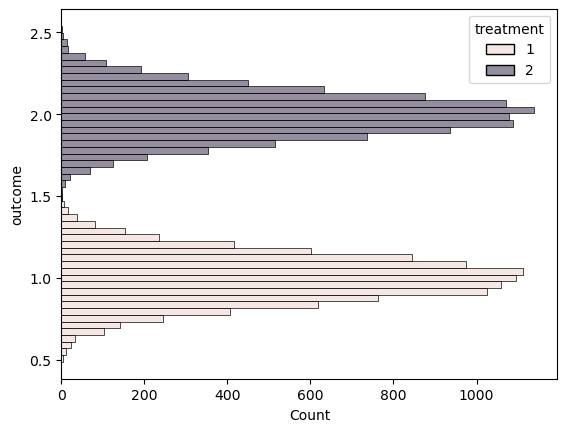

In [373]:
sns.histplot(data=df_fixed_schedule.groupby(["trial","treatment"]).mean(), y="outcome", hue="treatment", bins=50)

## "Play the Winner"-Bias
Let's assume a simple policy: we test both treatments one time, and then only choose the best one (equals a explore-then-commit policy with n=1).
This will induce a "play-the-winner"-bias. 

See also:
Bowden, J., & Trippa, L. (2017). Unbiased estimation for response adaptive clinical trials. Statistical Methods in Medical Research, 26(5), 2376–2388. https://doi.org/10.1177/0962280215597716

In [374]:
df = pd.DataFrame(columns=["outcome", "treatment", "trial"])
# Simple AB treatment schedule
df["treatment"] = [1,2] * n_observations * int(n_trials / 2)
df["outcome"] = (
    (df["treatment"] == 1) * np.random.normal(1,1, len(df)) +
    (df["treatment"] == 2) * np.random.normal(2,1, len(df))
)
df["trial"] = df.index // n_observations

# All rows are adaptive except the first two of every trial
df["adaptive"] = df.index % n_observations > 1
df_pivoted = df.loc[~df["adaptive"]].pivot(index="trial",values="outcome", columns="treatment")
df_pivoted["better_treatment"] = np.where(df_pivoted[1] > df_pivoted[2], 1, 2)

# Add the better_treatment to the original dataset
df = df.join(df_pivoted,on="trial")

# Set the adaptive treatments to the better treatment
df["treatment"] = np.where(df["adaptive"], df["better_treatment"], df["treatment"])

# Update the observations
df["outcome"] = np.where(df["adaptive"],
    (df["treatment"] == 1) * np.random.normal(1,1, len(df)) +
    (df["treatment"] == 2) * np.random.normal(2,1, len(df)),
                         df["outcome"]
)
df_play_the_winner = df

The "Play the Winner"-Rule deforms the bell curves.
Instead of one homogenous bell curve, both treatments show an addition of two bell curves: One very narrow for trials where we choose the respective treatment as winner, and one very wide one where the respective treatment lost and was therefore only sampled once. 

Because we generate a lot more data points for Treatment 2 (the better treatment), we see a narrower histogram, and the distribution for Treatment 1 is wider.

<Axes: xlabel='Count', ylabel='outcome'>

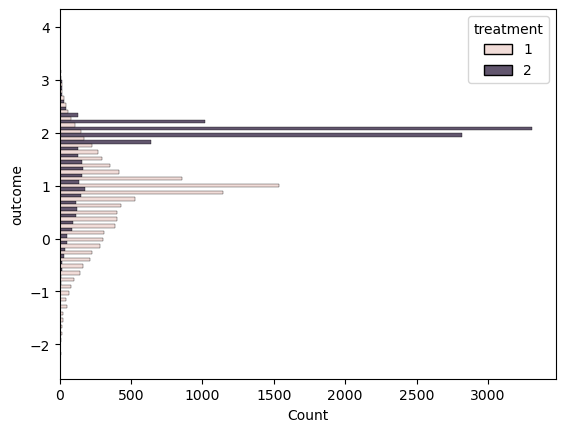

In [378]:
sns.histplot(data=df_play_the_winner.groupby(["trial","treatment"]).mean(), y="outcome", hue="treatment", bins=50, multiple="dodge")

We know want to compare the post-inference after both trials.
Therefore, we calculate the average treatment effect estimant over all trials, and average it.

We observe a small bias that makes the estimated treatment effect smaller than it is.

In [379]:
print(df_fixed_schedule.groupby(["trial", "treatment"]).mean()["outcome"][:,2].mean())
print(df_play_the_winner.groupby(["trial", "treatment"]).mean()["outcome"][:,2].mean())
print(f'Measured bias for treatment 2: {(df_fixed_schedule.groupby(["trial", "treatment"]).mean()["outcome"][:,2].mean() - df_play_the_winner.groupby(["trial", "treatment"]).mean()["outcome"][:, 2].mean()):.10f}')

1.9994945420878287
1.7766920690723729
Measured bias for treatment 2: 0.2228024730


### What do I need to do?
Best practice would be to test out the desired plolicy in a simulation study.
The bias should be smaller if using a less extreme version of an adaptive policy.
The estimate for Treatment 2 under the adaptive regime might be biased, but if analyzed correctyly will be better than under fixed schedule due to more sample points for the better treatment.

## Contextual Bias
Another potential bias we can get is contextual bias. If our policy introduces a dependency between contextual variable and treatment, and we do not control for it, we might take it as a treatment effect. Note that this is not only a problem with adaptive schedules, since it can also happen with fixed schedules.
However, it might be more likely with contextual bandit algorithms.
Let's consider a binary contextual variable c that can have a positive additive effect on outcome, and by chance is only 1 when we give treatment 2.

In [380]:
df = pd.DataFrame(columns=["outcome", "treatment", "trial"])
# Simple AB treatment schedule
df["treatment"] = [1,2] * n_observations * int(n_trials / 2)
df["trial"] = df.index // n_observations
df["context"] = df["treatment"] - 1
df["outcome"] = (
    (df["treatment"] == 1) * np.random.normal(1,1, len(df)) +
    (df["treatment"] == 2) * np.random.normal(2,1, len(df)) +
    df["context"]
)
df_fixed_schedule = df
df_play_the_winner = df

<Axes: xlabel='Count', ylabel='outcome'>

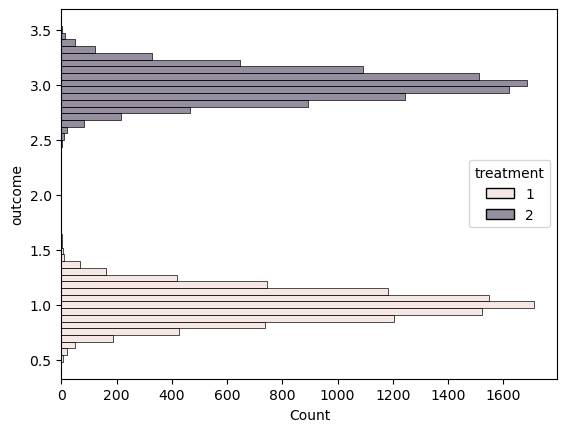

In [381]:
sns.histplot(data=df_play_the_winner.groupby(["trial","treatment"]).mean(), y="outcome", hue="treatment", bins=50)

A naive mean will overestimate the treatment effect to 3.

### What do I need to do?
Check if covariates are independent of treatment schedule, or control for non-independence.
Here, we have a strong dependence from time t <--> treatment. Adaptive policies might introduce more of these dependencies.
A special case of this might also be a baseline shift in the data. While a baseline shift violates our assumptions, modeling the baseline as a covariate might make the assumption valid again, but induce covariate bias.